If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [ ]:
# COMP534_assignment2
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

Use this first cell to import the necessary libraries.

In [29]:
# Import library
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import KFold
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import datetime
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from torch import amp
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# 1. **Data Management**


1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


In [30]:
# Data Management
DataPath = 'UCMerced_LandUse/Images' # Specify the dataset path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
try:
  Dataset = datasets.ImageFolder(root = DataPath) # Use ImageFolder to read the dataset
except:
  print("The dataset path is wrong, please check the path!")
  exit()

# Output basic information of the dataset
print("=== Dataset Overview ===")
print(f"Total classes: {len(Dataset.classes)}")
print(f"Total samples: {len(Dataset)}")
print(f"Sample img shape: {Dataset[0][0].size}")
print(f"Classes:{Dataset.classes}")

# Set hyperparameters
Inputsize = 256
batch_size = 32
Numworkers = min(4, os.cpu_count())
RandomSeed = 42
NFolds = 5
Mean=[0.4842, 0.4901, 0.4505]
STD=[0.2180, 0.2020, 0.1958]

# Read data tags
LabelList = []
for _, label in Dataset:
    LabelList.append(label)
Labelarray = np.array(LabelList) # Convert to NumPy array for easy processing

# Training set data augmentation and preprocessing
TrainTransform = transforms.Compose([
    transforms.Resize(Inputsize),
    transforms.RandomCrop(Inputsize),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(), # Convert to PyTorch Tensor
    transforms.Normalize(mean=Mean, std=STD) # Normalization
])

# Validation set preprocessing(No data augmentation)
TestTransform = transforms.Compose([
    transforms.Resize(Inputsize),
    transforms.CenterCrop(Inputsize),
    transforms.ToTensor(), # Convert to PyTorch Tensor
    transforms.Normalize(mean=Mean, std=STD) # Normalization
])

# Set the random seed to ensure that the experimental results can be reproduced
torch.manual_seed(RandomSeed)
np.random.seed(RandomSeed)
if device.type == 'cuda':
  torch.cuda.manual_seed_all(RandomSeed)

# 5-fold cross validation
kf = KFold(n_splits=NFolds, shuffle=True, random_state=RandomSeed)

# Data Index
Datasetsize = len(Dataset)
Indices = np.arange(len(Dataset)) # Generate sample index

Foldloaders = []
for fold, (TrainIdx, TestIdx) in enumerate(kf.split(Indices)):
    print(f"=== Preparing Fold {fold+1}/{NFolds} ===")

    TrainDataset = datasets.ImageFolder(root=DataPath, transform=TrainTransform)
    TestDataset = datasets.ImageFolder(root=DataPath, transform=TestTransform)

    TrainSubset = Subset(TrainDataset, TrainIdx)
    TestSubset = Subset(TestDataset, TestIdx)

    TrainLoader = DataLoader(TrainSubset, batch_size=batch_size, shuffle=True, num_workers=Numworkers)
    TestLoader = DataLoader(TestSubset, batch_size=batch_size, shuffle=False, num_workers=Numworkers)

    Foldloaders.append({
        'Train': TrainLoader,
        'Test': TestLoader,
        'TrainIdx': TrainIdx,
        'TestIdx': TestIdx
    })
print("Data preparation completed.")

device: cuda
=== Dataset Overview ===
Total classes: 21
Total samples: 2100
Sample img shape: (256, 256)
Classes:['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
=== Preparing Fold 1/5 ===
=== Preparing Fold 2/5 ===
=== Preparing Fold 3/5 ===
=== Preparing Fold 4/5 ===
=== Preparing Fold 5/5 ===
Data preparation completed.


---

# 2. **Neural Networks**


1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



In [31]:
# Own CNN
class LandCNN(nn.Module):
  def __init__(self, NumClasses=21):
    super(LandCNN, self).__init__()

    self.FeatureExtractor = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512*8*8, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024), # Accelerates convergence
        nn.Dropout(0.5),
        nn.Linear(1024, NumClasses)
    )

    self.InitialWeight()

  def forward(self, X):
    X = self.FeatureExtractor(X)
    X = torch.flatten(X, 1)
    X = self.Classifier(X)
    return X

  def InitialWeight(self):
    for j in self.modules():
      if isinstance(j, nn.Conv2d):
        nn.init.kaiming_normal_(j.weight, mode='fan_out', nonlinearity='relu')
        if j.bias is not None:
          nn.init.constant_(j.bias, 0)
      elif isinstance(j, nn.BatchNorm2d):
        nn.init.constant_(j.weight, 1)
      elif isinstance(j, nn.Linear):
        nn.init.normal_(j.weight, 0, 0.01)
        nn.init.constant_(j.bias, 0)

Model = LandCNN(NumClasses=len(Dataset.classes)).to(device)
print("=== Own CNN Architecture ===")
print(Model)


=== Own CNN Architecture ===
LandCNN(
  (FeatureExtractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [32]:
# Implement EfficientNetwork
def EfficientNet(ModelName='efficientnet_b0', pretrained=True, Numclasses=21):
    """Create and configure the EfficientNet model"""
    model = timm.create_model(
        ModelName,
        pretrained=pretrained,
        num_classes=Numclasses,
        drop_rate=0.2,
        drop_path_rate=0.1
    ).to(device)

    ParaGps = []
    # Transfer Learning
    if pretrained:
      ParaGps.extend([
        {'params': model.blocks[5].parameters(), 'lr': 1e-4},
        {'params': model.blocks[6].parameters(), 'lr': 1e-4},
        {'params': model.bn2.parameters(), 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 5e-4}
      ])
    # Training from scratch
    else:
      ParaGps.extend([
        {'params': model.conv_stem.parameters(), 'lr': 1e-5},  # stem
        {'params': model.bn1.parameters(), 'lr': 1e-5}, # BN
      ])
      for block in model.blocks:
        ParaGps.append({'params': block.parameters(), 'lr': 1e-4})
      ParaGps.extend([
          {'params': model.conv_head.parameters(), 'lr': 1e-4}, # conv_head
          {'params': model.bn2.parameters(), 'lr': 1e-4},# bn2
          {'params': model.classifier.parameters(), 'lr': 5e-4}
      ])

    return model, ParaGps

model, ParaGps = EfficientNet(pretrained=True)
print("=== EfficientNet-B0 Architecture ===")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Group coverage: {sum(p.numel() for g in ParaGps for p in g['params'])}")


=== EfficientNet-B0 Architecture ===
EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), st

In [33]:
# Implement Weighted Cross Entropy
Labelarray = np.array(Labelarray).astype(int)
ClassCounts = np.bincount(Labelarray)
ClassWeights = 1. / torch.tensor(ClassCounts+1e-6, dtype=torch.float).to(device)
Criterion = nn.CrossEntropyLoss(weight=ClassWeights)

# AdamW
Optimizer = AdamW(
    params=ParaGps,
    lr=3e-4,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

# Learning Rate Scheduler:Cosine annealing(https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
Scheduler = CosineAnnealingWarmRestarts(
    Optimizer,
    T_0=20,
    T_mult=2
)

Scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

def TrainStep(Model, TrainDataLoader, Optimizer, Criterion):
  Model.train()
  totalLoss = 0
  for batch in tqdm(TrainDataLoader, desc='training'):
    inputs, labels = batch[0].to(device), batch[1].to(device)
    Optimizer.zero_grad()
    outputs = Model(inputs)
    loss = Criterion(outputs, labels)
    loss.backward()
    Optimizer.step()
    totalLoss += loss.item()
  return totalLoss/len(TrainDataLoader)

def EvalStep(Model, TestDataLoader, Criterion):
  Model.eval()
  totalLoss, correct = 0, 0
  with torch.no_grad():
    for inputs, labels in TestDataLoader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = Model(inputs)
      loss = Criterion(outputs, labels)
      totalLoss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
  return totalLoss/len(TestDataLoader), correct/len(TestDataLoader.dataset)

# Early Stopping Mechanism
class EarlyStopping:
  def __init__(self, Patience=7, Delta=0.001):
    self.Patience = Patience
    self.Delta = Delta
    self.Counter = 0
    self.BestScore = None
    self.EarlyStop = False

  def __call__(self, ValLoss, Model):
    Score = -ValLoss
    if self.BestScore is None:
      self.BestScore = Score
      self.SaveCheckpoint(ValLoss, Model)
    elif Score < self.BestScore + self.Delta:
      self.Counter += 1
      if self.Counter >= self.Patience:
        self.EarlyStop = True
    else:
      self.BestScore = Score
      self.SaveCheckpoint(ValLoss, Model)
      self.Counter = 0

  def SaveCheckpoint(self, ValLoss, Model):
    print(f"Validation loss improved: {self.BestScore:.4f} → {ValLoss:.4f}. Saving model...")
    torch.save(Model.state_dict(), 'Checkpoint.pt')

def TrainModel(Model, TrainDataLoader, TestDataLoader, Optimizer, Criterion, Scheduler, EarlyStop, Epochs):
    TrainLosses = []
    ValLosses = []
    ValAccs = []
    for Epoch in range(Epochs):
      TrainLoss = TrainStep(Model, TrainDataLoader, Optimizer, Criterion)
      ValLoss, ValAcc = EvalStep(Model, TestDataLoader, Criterion)

      Scheduler.step()
      TrainLosses.append(TrainLoss)
      ValLosses.append(ValLoss)
      ValAccs.append(ValAcc)

      print(f"Epoch {Epoch+1}/{Epochs} | {TrainLoss:.4f} | Val Loss: {ValLoss:.4f} | Val Acc: {ValAcc:.2%}")

      EarlyStop(ValLoss, Model)
      if EarlyStop.EarlyStop:
        print("Early stopping triggered")
        break

    return TrainLosses, ValLosses, ValAccs


In [ ]:
# Train Own Model
def TrainOwnCnn(FoldLoaders, NumEpochs):
  AllTrainLosses = []
  AllValLosses = []
  AllValAccs = []

  ClassCounts = np.bincount(Labelarray)
  ClassWeights = 1. / torch.tensor(ClassCounts + 1e-6, dtype=torch.float).to(device)
  Criterion = nn.CrossEntropyLoss(weight=ClassWeights)

  for Fold, FoldData in enumerate(FoldLoaders):
    print(f"=== Training Fold {Fold+1}/{len(FoldLoaders)} ===")

    Model = LandCNN(NumClasses=len(Dataset.classes)).to(device)
    Optimizer = AdamW(params=Model.parameters(), lr=3e-4, weight_decay=0.05, betas=(0.9, 0.999))
    Scheduler = CosineAnnealingWarmRestarts(Optimizer, T_0=20, T_mult=2)
    Scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    EarlyStopper = EarlyStopping(Patience=7)

    TrainLosses = []
    ValLosses = []
    ValAccs = []

    for Epoch in range(NumEpochs):
      # === Training Phase ===
      Model.train()
      TrainLoss = 0.0
      for Batch in tqdm(FoldData['Train']):
        Inputs, Labels = Batch[0].to(device), Batch[1].to(device)
        Optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', enabled=(device.type == 'cuda')):
          Outputs = Model(Inputs)
          Loss = Criterion(Outputs, Labels)
          Scaler.scale(Loss).backward()
          Scaler.step(Optimizer)
          Scaler.update()
          TrainLoss += Loss.item()

      # === Verification Phase ===
      ValLoss, ValAcc = EvalStep(Model, FoldData['Test'], Criterion)
      AvgTrainLoss = TrainLoss / len(FoldData['Train'])
      TrainLosses.append(AvgTrainLoss)
      ValLosses.append(ValLoss)
      ValAccs.append(ValAcc)

      print(f"Epoch {Epoch+1}/{NumEpochs} | "
         f"Train Loss: {AvgTrainLoss:.4f} | "
         f"Val Loss: {ValLoss:.4f} | "
         f"Val Acc: {ValAcc:.2%}")

      # Early Stopping
      EarlyStopper(ValLoss, Model)
      if EarlyStopper.EarlyStop:
        print(f"Early stopping triggered at epoch {Epoch+1}")
        break

    torch.save(Model.state_dict(), f'LandCNN_Fold{Fold+1}_Best.pth')
    AllTrainLosses.append(TrainLosses)
    AllValLosses.append(ValLosses)
    AllValAccs.append(ValAccs)

  MeanTrainLosses = np.mean(np.array(AllTrainLosses), axis=0)
  MeanValLosses = np.mean(np.array(AllValLosses), axis=0)
  MeanValAccs = np.mean(np.array(AllValAccs), axis=0)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(MeanTrainLosses, label='Mean Train Loss', color='blue')
  plt.plot(MeanValLosses, label='Mean Val Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Mean Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.subplot(1, 2, 2)
  plt.plot(MeanValAccs, label='Mean Val Accuracy', color='green')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Mean Accuracy Curve')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return MeanTrainLosses, MeanValLosses, MeanValAccs

# 运行训练
NumEpochs = 15
MeanTrainLosses, MeanValLosses, MeanValAccs = TrainOwnCnn(Foldloaders, NumEpochs)


=== Training Fold 1/5 ===


100%|██████████| 53/53 [00:15<00:00,  3.39it/s]


Epoch 1/15 | Train Loss: 2.3727 | Val Loss: 1.9031 | Val Acc: 46.67%
Validation loss improved: -1.9031 → 1.9031. Saving model...


100%|██████████| 53/53 [00:16<00:00,  3.21it/s]


Epoch 2/15 | Train Loss: 1.8285 | Val Loss: 1.5485 | Val Acc: 61.90%
Validation loss improved: -1.5485 → 1.5485. Saving model...


100%|██████████| 53/53 [00:15<00:00,  3.51it/s]


Epoch 3/15 | Train Loss: 1.4954 | Val Loss: 1.3309 | Val Acc: 62.38%
Validation loss improved: -1.3309 → 1.3309. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 4/15 | Train Loss: 1.2529 | Val Loss: 1.0939 | Val Acc: 70.48%
Validation loss improved: -1.0939 → 1.0939. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.63it/s]


Epoch 5/15 | Train Loss: 1.0713 | Val Loss: 0.9777 | Val Acc: 66.90%
Validation loss improved: -0.9777 → 0.9777. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.66it/s]


Epoch 6/15 | Train Loss: 0.9724 | Val Loss: 1.0653 | Val Acc: 70.71%


100%|██████████| 53/53 [00:15<00:00,  3.39it/s]


Epoch 7/15 | Train Loss: 0.8615 | Val Loss: 0.8629 | Val Acc: 72.62%
Validation loss improved: -0.8629 → 0.8629. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 8/15 | Train Loss: 0.7772 | Val Loss: 0.6556 | Val Acc: 80.95%
Validation loss improved: -0.6556 → 0.6556. Saving model...


100%|██████████| 53/53 [00:15<00:00,  3.44it/s]


Epoch 9/15 | Train Loss: 0.7297 | Val Loss: 0.7917 | Val Acc: 75.71%


100%|██████████| 53/53 [00:14<00:00,  3.57it/s]


Epoch 10/15 | Train Loss: 0.6481 | Val Loss: 0.7211 | Val Acc: 80.24%


100%|██████████| 53/53 [00:14<00:00,  3.68it/s]


Epoch 11/15 | Train Loss: 0.6315 | Val Loss: 0.6527 | Val Acc: 78.10%
Validation loss improved: -0.6527 → 0.6527. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.63it/s]


Epoch 12/15 | Train Loss: 0.5656 | Val Loss: 0.6327 | Val Acc: 79.76%
Validation loss improved: -0.6327 → 0.6327. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.72it/s]


Epoch 13/15 | Train Loss: 0.5435 | Val Loss: 0.4658 | Val Acc: 87.38%
Validation loss improved: -0.4658 → 0.4658. Saving model...


100%|██████████| 53/53 [00:15<00:00,  3.41it/s]


Epoch 14/15 | Train Loss: 0.5239 | Val Loss: 0.6013 | Val Acc: 80.71%


100%|██████████| 53/53 [00:14<00:00,  3.67it/s]


Epoch 15/15 | Train Loss: 0.5111 | Val Loss: 0.4810 | Val Acc: 85.95%
=== Training Fold 2/5 ===


100%|██████████| 53/53 [00:14<00:00,  3.67it/s]


Epoch 1/15 | Train Loss: 2.3955 | Val Loss: 2.0291 | Val Acc: 39.52%
Validation loss improved: -2.0291 → 2.0291. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 2/15 | Train Loss: 1.8445 | Val Loss: 1.5022 | Val Acc: 62.62%
Validation loss improved: -1.5022 → 1.5022. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.66it/s]


Epoch 3/15 | Train Loss: 1.5226 | Val Loss: 1.3041 | Val Acc: 60.48%
Validation loss improved: -1.3041 → 1.3041. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.72it/s]


Epoch 4/15 | Train Loss: 1.3063 | Val Loss: 1.1181 | Val Acc: 68.57%
Validation loss improved: -1.1181 → 1.1181. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 5/15 | Train Loss: 1.1414 | Val Loss: 1.0033 | Val Acc: 68.81%
Validation loss improved: -1.0033 → 1.0033. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.70it/s]


Epoch 6/15 | Train Loss: 0.9964 | Val Loss: 0.8571 | Val Acc: 75.24%
Validation loss improved: -0.8571 → 0.8571. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.68it/s]


Epoch 7/15 | Train Loss: 0.8500 | Val Loss: 0.7933 | Val Acc: 74.29%
Validation loss improved: -0.7933 → 0.7933. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 8/15 | Train Loss: 0.8105 | Val Loss: 0.7846 | Val Acc: 77.14%
Validation loss improved: -0.7846 → 0.7846. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.62it/s]


Epoch 9/15 | Train Loss: 0.7492 | Val Loss: 0.7334 | Val Acc: 79.05%
Validation loss improved: -0.7334 → 0.7334. Saving model...


100%|██████████| 53/53 [00:16<00:00,  3.26it/s]


Epoch 10/15 | Train Loss: 0.6888 | Val Loss: 0.7118 | Val Acc: 77.62%
Validation loss improved: -0.7118 → 0.7118. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.67it/s]


Epoch 11/15 | Train Loss: 0.6382 | Val Loss: 0.6205 | Val Acc: 82.14%
Validation loss improved: -0.6205 → 0.6205. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 12/15 | Train Loss: 0.6157 | Val Loss: 0.5034 | Val Acc: 84.76%
Validation loss improved: -0.5034 → 0.5034. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.72it/s]


Epoch 13/15 | Train Loss: 0.5572 | Val Loss: 0.5839 | Val Acc: 81.67%


100%|██████████| 53/53 [00:15<00:00,  3.44it/s]


Epoch 14/15 | Train Loss: 0.5149 | Val Loss: 0.4991 | Val Acc: 84.52%
Validation loss improved: -0.4991 → 0.4991. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.67it/s]


Epoch 15/15 | Train Loss: 0.5047 | Val Loss: 0.5580 | Val Acc: 81.43%
=== Training Fold 3/5 ===


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 1/15 | Train Loss: 2.4526 | Val Loss: 1.9979 | Val Acc: 39.52%
Validation loss improved: -1.9979 → 1.9979. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.56it/s]


Epoch 2/15 | Train Loss: 1.8382 | Val Loss: 1.6025 | Val Acc: 50.71%
Validation loss improved: -1.6025 → 1.6025. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.68it/s]


Epoch 3/15 | Train Loss: 1.4760 | Val Loss: 1.4419 | Val Acc: 61.43%
Validation loss improved: -1.4419 → 1.4419. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 4/15 | Train Loss: 1.3211 | Val Loss: 1.3328 | Val Acc: 62.14%
Validation loss improved: -1.3328 → 1.3328. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.65it/s]


Epoch 5/15 | Train Loss: 1.1369 | Val Loss: 1.1348 | Val Acc: 65.48%
Validation loss improved: -1.1348 → 1.1348. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.59it/s]


Epoch 6/15 | Train Loss: 1.0106 | Val Loss: 3.4882 | Val Acc: 48.57%


100%|██████████| 53/53 [00:14<00:00,  3.73it/s]


Epoch 7/15 | Train Loss: 0.9727 | Val Loss: 0.9567 | Val Acc: 72.14%
Validation loss improved: -0.9567 → 0.9567. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.72it/s]


Epoch 8/15 | Train Loss: 0.8794 | Val Loss: 0.8648 | Val Acc: 74.29%
Validation loss improved: -0.8648 → 0.8648. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 9/15 | Train Loss: 0.7683 | Val Loss: 0.8937 | Val Acc: 73.57%


100%|██████████| 53/53 [00:15<00:00,  3.44it/s]


Epoch 10/15 | Train Loss: 0.7305 | Val Loss: 0.7748 | Val Acc: 80.24%
Validation loss improved: -0.7748 → 0.7748. Saving model...


100%|██████████| 53/53 [00:15<00:00,  3.48it/s]


Epoch 11/15 | Train Loss: 0.6512 | Val Loss: 0.6555 | Val Acc: 80.24%
Validation loss improved: -0.6555 → 0.6555. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 12/15 | Train Loss: 0.5883 | Val Loss: 0.5694 | Val Acc: 82.62%
Validation loss improved: -0.5694 → 0.5694. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.61it/s]


Epoch 13/15 | Train Loss: 0.5621 | Val Loss: 0.6793 | Val Acc: 80.95%


100%|██████████| 53/53 [00:14<00:00,  3.70it/s]


Epoch 14/15 | Train Loss: 0.5260 | Val Loss: 0.5386 | Val Acc: 80.71%
Validation loss improved: -0.5386 → 0.5386. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.65it/s]


Epoch 15/15 | Train Loss: 0.4869 | Val Loss: 0.5632 | Val Acc: 84.52%
=== Training Fold 4/5 ===


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 1/15 | Train Loss: 2.3893 | Val Loss: 2.0496 | Val Acc: 38.81%
Validation loss improved: -2.0496 → 2.0496. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.58it/s]


Epoch 2/15 | Train Loss: 1.7574 | Val Loss: 1.6142 | Val Acc: 54.76%
Validation loss improved: -1.6142 → 1.6142. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 3/15 | Train Loss: 1.4586 | Val Loss: 1.4497 | Val Acc: 58.33%
Validation loss improved: -1.4497 → 1.4497. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 4/15 | Train Loss: 1.2058 | Val Loss: 1.2230 | Val Acc: 62.38%
Validation loss improved: -1.2230 → 1.2230. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.75it/s]


Epoch 5/15 | Train Loss: 1.0890 | Val Loss: 1.1648 | Val Acc: 67.62%
Validation loss improved: -1.1648 → 1.1648. Saving model...


100%|██████████| 53/53 [00:15<00:00,  3.50it/s]


Epoch 6/15 | Train Loss: 0.9606 | Val Loss: 1.1561 | Val Acc: 66.90%
Validation loss improved: -1.1561 → 1.1561. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 7/15 | Train Loss: 0.8536 | Val Loss: 1.0440 | Val Acc: 68.57%
Validation loss improved: -1.0440 → 1.0440. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.71it/s]


Epoch 8/15 | Train Loss: 0.7513 | Val Loss: 0.9148 | Val Acc: 72.62%
Validation loss improved: -0.9148 → 0.9148. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.75it/s]


Epoch 9/15 | Train Loss: 0.6775 | Val Loss: 0.9195 | Val Acc: 73.10%


100%|██████████| 53/53 [00:14<00:00,  3.54it/s]


Epoch 10/15 | Train Loss: 0.6297 | Val Loss: 0.7748 | Val Acc: 75.95%
Validation loss improved: -0.7748 → 0.7748. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.74it/s]


Epoch 11/15 | Train Loss: 0.6293 | Val Loss: 0.7804 | Val Acc: 76.90%


100%|██████████| 53/53 [00:14<00:00,  3.58it/s]


Epoch 12/15 | Train Loss: 0.5788 | Val Loss: 0.8595 | Val Acc: 74.05%


100%|██████████| 53/53 [00:14<00:00,  3.73it/s]


Epoch 13/15 | Train Loss: 0.5217 | Val Loss: 0.7169 | Val Acc: 75.00%
Validation loss improved: -0.7169 → 0.7169. Saving model...


100%|██████████| 53/53 [00:16<00:00,  3.15it/s]


Epoch 14/15 | Train Loss: 0.4682 | Val Loss: 0.7088 | Val Acc: 78.10%
Validation loss improved: -0.7088 → 0.7088. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.69it/s]


Epoch 15/15 | Train Loss: 0.4328 | Val Loss: 0.7945 | Val Acc: 78.10%
=== Training Fold 5/5 ===


100%|██████████| 53/53 [00:14<00:00,  3.76it/s]


Epoch 1/15 | Train Loss: 2.4146 | Val Loss: 2.0391 | Val Acc: 35.95%
Validation loss improved: -2.0391 → 2.0391. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.72it/s]


Epoch 2/15 | Train Loss: 1.8634 | Val Loss: 1.6196 | Val Acc: 56.43%
Validation loss improved: -1.6196 → 1.6196. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.66it/s]


Epoch 3/15 | Train Loss: 1.5334 | Val Loss: 1.5501 | Val Acc: 60.24%
Validation loss improved: -1.5501 → 1.5501. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.67it/s]


Epoch 4/15 | Train Loss: 1.3706 | Val Loss: 1.1651 | Val Acc: 69.76%
Validation loss improved: -1.1651 → 1.1651. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.73it/s]


Epoch 5/15 | Train Loss: 1.1717 | Val Loss: 0.9592 | Val Acc: 73.57%
Validation loss improved: -0.9592 → 0.9592. Saving model...


100%|██████████| 53/53 [00:14<00:00,  3.62it/s]


Epoch 6/15 | Train Loss: 1.0000 | Val Loss: 0.9131 | Val Acc: 75.71%
Validation loss improved: -0.9131 → 0.9131. Saving model...


 25%|██▍       | 13/53 [00:03<00:10,  3.78it/s]

=== Training EfficientNet from Scratch ===
=== Training Fold 1/5 ===


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 1/10 | 3.3253 | Val Loss: 3.4398 | Val Acc: 9.05%
Validation loss improved: -3.4398 → 3.4398. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 2/10 | 3.1468 | Val Loss: 3.2571 | Val Acc: 16.90%
Validation loss improved: -3.2571 → 3.2571. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 3/10 | 3.0870 | Val Loss: 3.0405 | Val Acc: 20.48%
Validation loss improved: -3.0405 → 3.0405. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 4/10 | 2.8541 | Val Loss: 2.7503 | Val Acc: 23.10%
Validation loss improved: -2.7503 → 2.7503. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.38it/s]


Epoch 5/10 | 2.7984 | Val Loss: 2.4765 | Val Acc: 30.95%
Validation loss improved: -2.4765 → 2.4765. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]


Epoch 6/10 | 2.6852 | Val Loss: 3.2906 | Val Acc: 32.14%


training: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]


Epoch 7/10 | 2.5591 | Val Loss: 2.5536 | Val Acc: 32.14%


training: 100%|██████████| 53/53 [00:16<00:00,  3.17it/s]


Epoch 8/10 | 2.5279 | Val Loss: 2.1394 | Val Acc: 36.90%
Validation loss improved: -2.1394 → 2.1394. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 9/10 | 2.4524 | Val Loss: 2.0761 | Val Acc: 38.33%
Validation loss improved: -2.0761 → 2.0761. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]


Epoch 10/10 | 2.3697 | Val Loss: 2.2712 | Val Acc: 38.57%
=== Training Fold 2/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.20it/s]


Epoch 1/10 | 3.3309 | Val Loss: 2.9947 | Val Acc: 7.62%
Validation loss improved: -2.9947 → 2.9947. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.36it/s]


Epoch 2/10 | 3.2022 | Val Loss: 2.9198 | Val Acc: 11.19%
Validation loss improved: -2.9198 → 2.9198. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s]


Epoch 3/10 | 3.0422 | Val Loss: 2.7127 | Val Acc: 17.62%
Validation loss improved: -2.7127 → 2.7127. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 4/10 | 2.9570 | Val Loss: 3.2520 | Val Acc: 20.00%


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 5/10 | 2.9626 | Val Loss: 2.5373 | Val Acc: 20.24%
Validation loss improved: -2.5373 → 2.5373. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 6/10 | 2.7657 | Val Loss: 2.5427 | Val Acc: 22.14%


training: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]


Epoch 7/10 | 2.7513 | Val Loss: 2.4350 | Val Acc: 26.19%
Validation loss improved: -2.4350 → 2.4350. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]


Epoch 8/10 | 2.6423 | Val Loss: 2.6024 | Val Acc: 25.00%


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 9/10 | 2.5932 | Val Loss: 2.3699 | Val Acc: 26.90%
Validation loss improved: -2.3699 → 2.3699. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s]


Epoch 10/10 | 2.5307 | Val Loss: 2.1798 | Val Acc: 28.10%
Validation loss improved: -2.1798 → 2.1798. Saving model...
=== Training Fold 3/5 ===


training: 100%|██████████| 53/53 [00:17<00:00,  2.99it/s]


Epoch 1/10 | 3.2717 | Val Loss: 3.6133 | Val Acc: 6.43%
Validation loss improved: -3.6133 → 3.6133. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 2/10 | 3.0884 | Val Loss: 3.1079 | Val Acc: 11.90%
Validation loss improved: -3.1079 → 3.1079. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 3/10 | 3.0262 | Val Loss: 2.7610 | Val Acc: 20.95%
Validation loss improved: -2.7610 → 2.7610. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.22it/s]


Epoch 4/10 | 2.8550 | Val Loss: 2.7587 | Val Acc: 21.67%
Validation loss improved: -2.7587 → 2.7587. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.31it/s]


Epoch 5/10 | 2.7916 | Val Loss: 2.8610 | Val Acc: 28.33%


training: 100%|██████████| 53/53 [00:16<00:00,  3.21it/s]


Epoch 6/10 | 2.6993 | Val Loss: 2.3952 | Val Acc: 29.76%
Validation loss improved: -2.3952 → 2.3952. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 7/10 | 2.5919 | Val Loss: 3.1802 | Val Acc: 31.19%


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 8/10 | 2.5197 | Val Loss: 2.8913 | Val Acc: 32.62%


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 9/10 | 2.4845 | Val Loss: 2.2498 | Val Acc: 34.05%
Validation loss improved: -2.2498 → 2.2498. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 10/10 | 2.3953 | Val Loss: 2.4402 | Val Acc: 37.62%
=== Training Fold 4/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.19it/s]


Epoch 1/10 | 3.3969 | Val Loss: 2.9570 | Val Acc: 5.48%
Validation loss improved: -2.9570 → 2.9570. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]


Epoch 2/10 | 3.1568 | Val Loss: 2.9150 | Val Acc: 12.86%
Validation loss improved: -2.9150 → 2.9150. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s]


Epoch 3/10 | 3.1055 | Val Loss: 2.7976 | Val Acc: 15.95%
Validation loss improved: -2.7976 → 2.7976. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 4/10 | 3.0828 | Val Loss: 2.7118 | Val Acc: 17.38%
Validation loss improved: -2.7118 → 2.7118. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.31it/s]


Epoch 5/10 | 2.8534 | Val Loss: 2.5602 | Val Acc: 26.67%
Validation loss improved: -2.5602 → 2.5602. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.20it/s]


Epoch 6/10 | 2.8077 | Val Loss: 2.4057 | Val Acc: 25.24%
Validation loss improved: -2.4057 → 2.4057. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 7/10 | 2.6525 | Val Loss: 2.2611 | Val Acc: 28.81%
Validation loss improved: -2.2611 → 2.2611. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 8/10 | 2.5556 | Val Loss: 2.1849 | Val Acc: 31.43%
Validation loss improved: -2.1849 → 2.1849. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.24it/s]


Epoch 9/10 | 2.4825 | Val Loss: 2.1205 | Val Acc: 37.62%
Validation loss improved: -2.1205 → 2.1205. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.36it/s]


Epoch 10/10 | 2.4311 | Val Loss: 2.1866 | Val Acc: 36.19%
=== Training Fold 5/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.17it/s]


Epoch 1/10 | 3.3597 | Val Loss: 3.3725 | Val Acc: 12.14%
Validation loss improved: -3.3725 → 3.3725. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]


Epoch 2/10 | 3.1333 | Val Loss: 3.0204 | Val Acc: 13.33%
Validation loss improved: -3.0204 → 3.0204. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]


Epoch 3/10 | 3.0454 | Val Loss: 3.0320 | Val Acc: 16.67%


training: 100%|██████████| 53/53 [00:16<00:00,  3.19it/s]


Epoch 4/10 | 2.9271 | Val Loss: 2.7993 | Val Acc: 20.24%
Validation loss improved: -2.7993 → 2.7993. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 5/10 | 2.8564 | Val Loss: 2.7707 | Val Acc: 20.00%
Validation loss improved: -2.7707 → 2.7707. Saving model...


training: 100%|██████████| 53/53 [00:17<00:00,  3.12it/s]


Epoch 6/10 | 2.7821 | Val Loss: 2.5508 | Val Acc: 23.81%
Validation loss improved: -2.5508 → 2.5508. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s]


Epoch 7/10 | 2.6333 | Val Loss: 2.5225 | Val Acc: 25.95%
Validation loss improved: -2.5225 → 2.5225. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 8/10 | 2.5492 | Val Loss: 2.5571 | Val Acc: 30.24%


training: 100%|██████████| 53/53 [00:16<00:00,  3.18it/s]


Epoch 9/10 | 2.5145 | Val Loss: 2.4625 | Val Acc: 31.67%
Validation loss improved: -2.4625 → 2.4625. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 10/10 | 2.5345 | Val Loss: 2.5256 | Val Acc: 30.71%
=== Fine-tuning EfficientNet ===
=== Training Fold 1/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.15it/s]


Epoch 1/10 | 2.8083 | Val Loss: 1.3430 | Val Acc: 60.71%
Validation loss improved: -1.3430 → 1.3430. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 2/10 | 1.0501 | Val Loss: 0.5486 | Val Acc: 81.90%
Validation loss improved: -0.5486 → 0.5486. Saving model...


training: 100%|██████████| 53/53 [00:17<00:00,  3.11it/s]


Epoch 3/10 | 0.5699 | Val Loss: 0.3219 | Val Acc: 88.57%
Validation loss improved: -0.3219 → 0.3219. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s]


Epoch 4/10 | 0.3615 | Val Loss: 0.2049 | Val Acc: 92.14%
Validation loss improved: -0.2049 → 0.2049. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]


Epoch 5/10 | 0.2410 | Val Loss: 0.1526 | Val Acc: 94.52%
Validation loss improved: -0.1526 → 0.1526. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.14it/s]


Epoch 6/10 | 0.2057 | Val Loss: 0.1284 | Val Acc: 94.76%
Validation loss improved: -0.1284 → 0.1284. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.25it/s]


Epoch 7/10 | 0.1839 | Val Loss: 0.0908 | Val Acc: 97.38%
Validation loss improved: -0.0908 → 0.0908. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s]


Epoch 8/10 | 0.1542 | Val Loss: 0.0910 | Val Acc: 96.43%


training: 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]


Epoch 9/10 | 0.1476 | Val Loss: 0.0797 | Val Acc: 97.62%
Validation loss improved: -0.0797 → 0.0797. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.26it/s]


Epoch 10/10 | 0.1116 | Val Loss: 0.0724 | Val Acc: 98.10%
Validation loss improved: -0.0724 → 0.0724. Saving model...
=== Training Fold 2/5 ===


training: 100%|██████████| 53/53 [00:17<00:00,  3.08it/s]


Epoch 1/10 | 2.7180 | Val Loss: 1.3009 | Val Acc: 59.76%
Validation loss improved: -1.3009 → 1.3009. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 2/10 | 1.0528 | Val Loss: 0.6326 | Val Acc: 79.76%
Validation loss improved: -0.6326 → 0.6326. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.31it/s]


Epoch 3/10 | 0.6203 | Val Loss: 0.3575 | Val Acc: 88.33%
Validation loss improved: -0.3575 → 0.3575. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 4/10 | 0.4057 | Val Loss: 0.2442 | Val Acc: 92.14%
Validation loss improved: -0.2442 → 0.2442. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 5/10 | 0.2800 | Val Loss: 0.1939 | Val Acc: 94.05%
Validation loss improved: -0.1939 → 0.1939. Saving model...


training: 100%|██████████| 53/53 [00:17<00:00,  3.06it/s]


Epoch 6/10 | 0.2371 | Val Loss: 0.1588 | Val Acc: 95.00%
Validation loss improved: -0.1588 → 0.1588. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.22it/s]


Epoch 7/10 | 0.1708 | Val Loss: 0.1579 | Val Acc: 95.00%


training: 100%|██████████| 53/53 [00:16<00:00,  3.22it/s]


Epoch 8/10 | 0.1553 | Val Loss: 0.1311 | Val Acc: 95.95%
Validation loss improved: -0.1311 → 0.1311. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.12it/s]


Epoch 9/10 | 0.1224 | Val Loss: 0.1188 | Val Acc: 96.43%
Validation loss improved: -0.1188 → 0.1188. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.31it/s]


Epoch 10/10 | 0.1054 | Val Loss: 0.1177 | Val Acc: 95.95%
Validation loss improved: -0.1177 → 0.1177. Saving model...
=== Training Fold 3/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.24it/s]


Epoch 1/10 | 2.7368 | Val Loss: 1.4331 | Val Acc: 55.24%
Validation loss improved: -1.4331 → 1.4331. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 2/10 | 1.0696 | Val Loss: 0.6239 | Val Acc: 81.43%
Validation loss improved: -0.6239 → 0.6239. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.16it/s]


Epoch 3/10 | 0.5966 | Val Loss: 0.4283 | Val Acc: 85.24%
Validation loss improved: -0.4283 → 0.4283. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 4/10 | 0.3779 | Val Loss: 0.3041 | Val Acc: 88.33%
Validation loss improved: -0.3041 → 0.3041. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 5/10 | 0.2854 | Val Loss: 0.2339 | Val Acc: 92.62%
Validation loss improved: -0.2339 → 0.2339. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.18it/s]


Epoch 6/10 | 0.2195 | Val Loss: 0.1996 | Val Acc: 93.57%
Validation loss improved: -0.1996 → 0.1996. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]


Epoch 7/10 | 0.1752 | Val Loss: 0.1820 | Val Acc: 93.10%
Validation loss improved: -0.1820 → 0.1820. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.26it/s]


Epoch 8/10 | 0.1464 | Val Loss: 0.1626 | Val Acc: 94.05%
Validation loss improved: -0.1626 → 0.1626. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 9/10 | 0.1215 | Val Loss: 0.1358 | Val Acc: 94.76%
Validation loss improved: -0.1358 → 0.1358. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s]


Epoch 10/10 | 0.1103 | Val Loss: 0.1273 | Val Acc: 95.24%
Validation loss improved: -0.1273 → 0.1273. Saving model...
=== Training Fold 4/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.21it/s]


Epoch 1/10 | 2.6876 | Val Loss: 1.2079 | Val Acc: 64.76%
Validation loss improved: -1.2079 → 1.2079. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 2/10 | 1.0142 | Val Loss: 0.5654 | Val Acc: 83.57%
Validation loss improved: -0.5654 → 0.5654. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.23it/s]


Epoch 3/10 | 0.5273 | Val Loss: 0.3142 | Val Acc: 91.67%
Validation loss improved: -0.3142 → 0.3142. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 4/10 | 0.3700 | Val Loss: 0.2320 | Val Acc: 93.57%
Validation loss improved: -0.2320 → 0.2320. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 5/10 | 0.2539 | Val Loss: 0.1784 | Val Acc: 96.19%
Validation loss improved: -0.1784 → 0.1784. Saving model...


training: 100%|██████████| 53/53 [00:17<00:00,  3.06it/s]


Epoch 6/10 | 0.2307 | Val Loss: 0.1691 | Val Acc: 94.76%
Validation loss improved: -0.1691 → 0.1691. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 7/10 | 0.1805 | Val Loss: 0.1505 | Val Acc: 94.76%
Validation loss improved: -0.1505 → 0.1505. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.31it/s]


Epoch 8/10 | 0.1377 | Val Loss: 0.1309 | Val Acc: 96.19%
Validation loss improved: -0.1309 → 0.1309. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]


Epoch 9/10 | 0.1103 | Val Loss: 0.1096 | Val Acc: 97.14%
Validation loss improved: -0.1096 → 0.1096. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s]


Epoch 10/10 | 0.1233 | Val Loss: 0.0976 | Val Acc: 97.14%
Validation loss improved: -0.0976 → 0.0976. Saving model...
=== Training Fold 5/5 ===


training: 100%|██████████| 53/53 [00:16<00:00,  3.13it/s]


Epoch 1/10 | 2.6513 | Val Loss: 1.3378 | Val Acc: 59.29%
Validation loss improved: -1.3378 → 1.3378. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]


Epoch 2/10 | 1.0428 | Val Loss: 0.6016 | Val Acc: 81.67%
Validation loss improved: -0.6016 → 0.6016. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]


Epoch 3/10 | 0.5535 | Val Loss: 0.3262 | Val Acc: 90.71%
Validation loss improved: -0.3262 → 0.3262. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.24it/s]


Epoch 4/10 | 0.3586 | Val Loss: 0.2476 | Val Acc: 92.38%
Validation loss improved: -0.2476 → 0.2476. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]


Epoch 5/10 | 0.2825 | Val Loss: 0.1895 | Val Acc: 94.76%
Validation loss improved: -0.1895 → 0.1895. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.18it/s]


Epoch 6/10 | 0.2408 | Val Loss: 0.1735 | Val Acc: 94.76%
Validation loss improved: -0.1735 → 0.1735. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


Epoch 7/10 | 0.1537 | Val Loss: 0.1410 | Val Acc: 94.76%
Validation loss improved: -0.1410 → 0.1410. Saving model...


training: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]


Epoch 8/10 | 0.1550 | Val Loss: 0.1189 | Val Acc: 95.95%
Validation loss improved: -0.1189 → 0.1189. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.19it/s]


Epoch 9/10 | 0.1406 | Val Loss: 0.1057 | Val Acc: 95.71%
Validation loss improved: -0.1057 → 0.1057. Saving model...


training: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s]


Epoch 10/10 | 0.1005 | Val Loss: 0.1093 | Val Acc: 96.43%
=== Results of Scratch ===
MeanTrainLoss: [3.3369013  3.14549317 3.06124382 2.93520006 2.85246263 2.74799301
 2.63761669 2.55893764 2.5054064  2.45226165]
MeanValLoss: [3.27544722 3.04403025 2.86875943 2.85442756 2.64112018 2.6370159
 2.59047953 2.47499896 2.25577445 2.32067467]
MeanValAcc: [0.08142857 0.13238095 0.18333333 0.2047619  0.25238095 0.26619048
 0.28857143 0.31238095 0.33714286 0.34238095]
=== Results of Fine-tuning ===


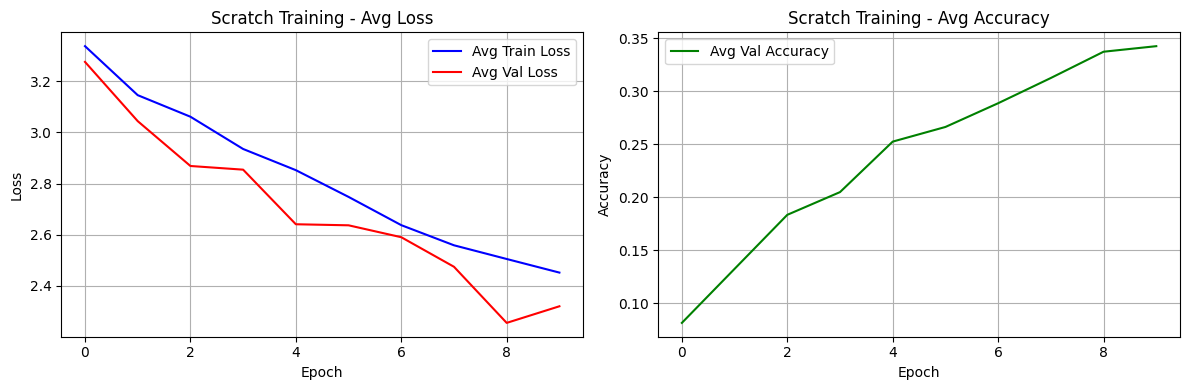

MeanTrainLoss: {MeanTrainLosses_Finetune}
MeanValLoss: {MeanValLosses_Finetune}
MeanValAcc: {MeanValAccs_Finetune}


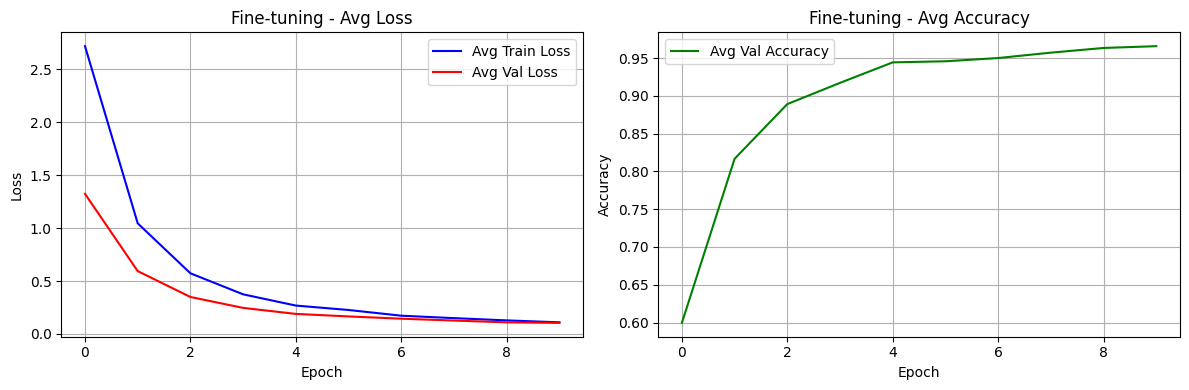

In [17]:
# train the existing architecture using at least 2 different strategies
# Scratch Training
def EfficientNetTraining(Foldloaders, NumEpochs):
  """Train EfficientNet use two strategies: scratch training and fine-tuning"""
  AllScratchResults = {'TrainLosses': [], 'ValLosses': [], 'ValAccs': []}
  AllFinetuneResults = {'TrainLosses': [], 'ValLosses': [], 'ValAccs': []}
  ClassCounts = np.bincount(Labelarray)
  ClassWeights = 1. / torch.tensor(ClassCounts+1e-6, dtype=torch.float).to(device)
  Criterion = nn.CrossEntropyLoss(weight=ClassWeights)

  """Create EfficientNet model for scratch Training"""
  print("=== Training EfficientNet from Scratch ===")
  for Fold, FoldData in enumerate(Foldloaders):
    print(f"=== Training Fold {Fold+1}/{len(Foldloaders)} ===")
    Model, ParaGps = EfficientNet(pretrained=False, Numclasses=21)
    Model = Model.to(device)

    Optimizer = AdamW(
      params=ParaGps,
      lr=3e-4,
      weight_decay=0.05,
      betas=(0.9, 0.999)
    )

    Scheduler = CosineAnnealingWarmRestarts(
      Optimizer,
      T_0=20,
      T_mult=2
    )

    Scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    EarlyStopper = EarlyStopping(Patience=7)

    TrainLosses, ValLosses, ValAccs = TrainModel(
      Model,
      FoldData['Train'],
      FoldData['Test'],
      Optimizer,
      Criterion,
      Scheduler,
      EarlyStopper,
      NumEpochs
    )

    AllScratchResults['TrainLosses'].append(TrainLosses)
    AllScratchResults['ValLosses'].append(ValLosses)
    AllScratchResults['ValAccs'].append(ValAccs)

    torch.save(Model.state_dict(), f'EfficientNet_Scratch_Fold{Fold+1}_Best.pth')

  # Strategy 2: Fine-tuning (pretrained=True)
  print("=== Fine-tuning EfficientNet ===")
  for Fold, FoldData in enumerate(Foldloaders):
    print(f"=== Training Fold {Fold+1}/{len(Foldloaders)} ===")
    Model, ParaGps = EfficientNet(pretrained=True, Numclasses=21)
    Model = Model.to(device)

    Optimizer = AdamW(
      params=ParaGps,
      lr=1e-4,  # Lower learning rate for fine-tuning
      weight_decay=0.05,
      betas=(0.9, 0.999)
    )

    Scheduler = CosineAnnealingWarmRestarts(
      Optimizer,
      T_0=20,
      T_mult=2
    )

    EarlyStopper = EarlyStopping(Patience=7)
    TrainLosses, ValLosses, ValAccs = TrainModel(
      Model,
      FoldData['Train'],
      FoldData['Test'],
      Optimizer,
      Criterion,
      Scheduler,
      EarlyStopper,
      NumEpochs
    )

    AllFinetuneResults['TrainLosses'].append(TrainLosses)
    AllFinetuneResults['ValLosses'].append(ValLosses)
    AllFinetuneResults['ValAccs'].append(ValAccs)

    torch.save(Model.state_dict(), f'EfficientNet_Finetune_Fold{Fold+1}_Best.pth')

  def ComputeMeanMetrics(AllResults):
    MeanTrainLosses = np.mean(AllResults['TrainLosses'], axis=0)
    MeanValLosses = np.mean(AllResults['ValLosses'], axis=0)
    MeanValAccs = np.mean(AllResults['ValAccs'], axis=0)
    return MeanTrainLosses, MeanValLosses, MeanValAccs

  MeanTrainLosses_Scratch, MeanValLosses_Scratch, MeanValAccs_Scratch = ComputeMeanMetrics(AllScratchResults)
  MeanTrainLosses_Finetune, MeanValLosses_Finetune, MeanValAccs_Finetune = ComputeMeanMetrics(AllFinetuneResults)

  def Plot(MeanTrainLosses, MeanValLosses, MeanValAccs, Title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(MeanTrainLosses, label='Avg Train Loss', color='blue')
    plt.plot(MeanValLosses, label='Avg Val Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{Title} - Avg Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(MeanValAccs, label='Avg Val Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{Title} - Avg Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

  print("=== Results of Scratch ===")
  Plot(MeanTrainLosses_Scratch, MeanValLosses_Scratch, MeanValAccs_Scratch, 'Scratch Training')
  print("=== Results of Fine-tuning ===")
  Plot(MeanTrainLosses_Finetune, MeanValLosses_Finetune, MeanValAccs_Finetune, 'Fine-tuning')

  return {
    'Scratch': AllScratchResults,
    'Finetune': AllFinetuneResults
  }

# Execute the training
NumEpochs = 10
Results = EfficientNetTraining(Foldloaders, NumEpochs)

---

# 3. **Evaluate models**

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


Test Loss: 0.0724
Test Accuracy: 98.10%
Precision: 0.9844
Recall: 0.9810
F1-Score: 0.9813


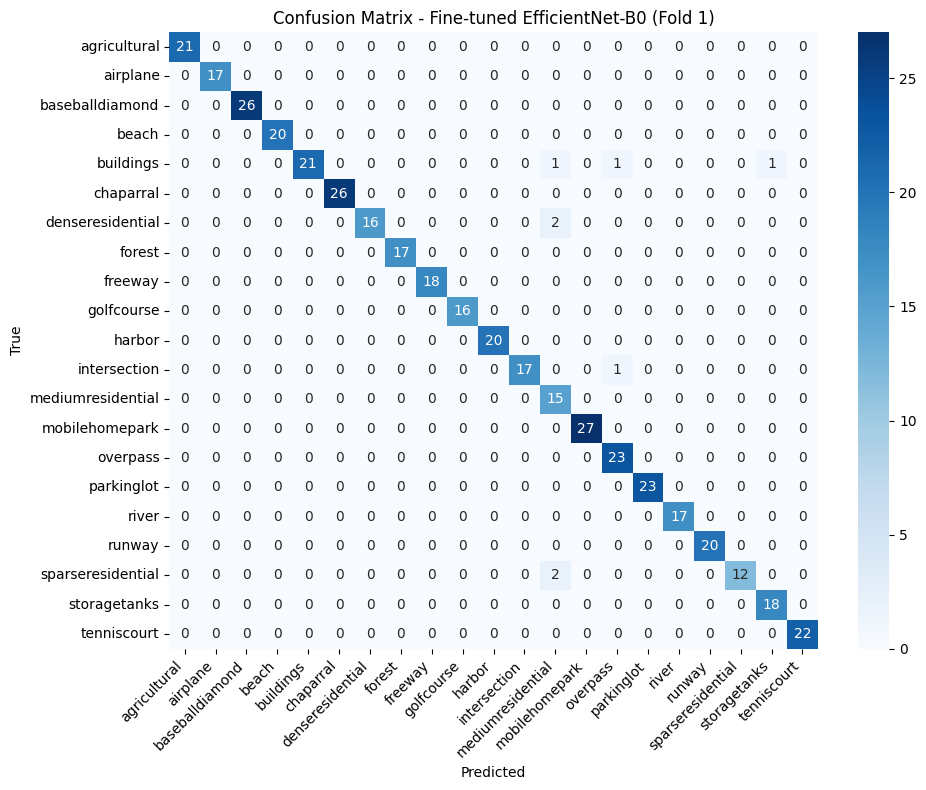

In [18]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best fine-tuned model (assuming Fold 1 as an example; adjust as needed)
best_fold = 1  # Replace with the fold yielding the best validation accuracy
Model, ParaGps = EfficientNet(pretrained=True, Numclasses=21)
Model = Model.to(device)
Model.load_state_dict(torch.load(f'EfficientNet_Finetune_Fold{best_fold}_Best.pth'))
Model.eval()

# Define the loss criterion (same as training)
ClassCounts = np.bincount(Labelarray)
ClassWeights = 1. / torch.tensor(ClassCounts + 1e-6, dtype=torch.float).to(device)
Criterion = nn.CrossEntropyLoss(weight=ClassWeights)

# Evaluate on the test set for the best fold
def evaluate_best_model(Model, TestDataLoader, Criterion):
    Model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in TestDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = Model(inputs)
            loss = Criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(TestDataLoader)
    accuracy = correct / len(TestDataLoader.dataset)
    return avg_loss, accuracy, all_preds, all_labels

# Get the test loader for the best fold
TestLoader = Foldloaders[best_fold - 1]['Test']

# Run evaluation
test_loss, test_accuracy, test_preds, test_labels = evaluate_best_model(Model, TestLoader, Criterion)

# Compute additional metrics
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Dataset.classes, yticklabels=Dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Fine-tuned EfficientNet-B0 (Fold {best_fold})')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()